<a href="https://colab.research.google.com/github/kazishuvo22/fastMRI-Reconstruction/blob/master/test_data2npy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loads test data and convert to npy for running predictions

In [ ]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import support as s
from tqdm import tqdm
import transforms as T
import tensorflow as tf
from subsample import RandomMaskFunc


As there is missing fastmri folder
from fastMRI.data import transforms as T

from fastMRI.common.subsample import RandomMaskFunc

In [ ]:
TEST_DIR_PATH  = "/content/drive/My Drive/CSE499N/Test"

In [ ]:
TEST_IMAGES_DIR_PATH  = glob.glob(os.path.join(TEST_DIR_PATH,"*.h5"))
len(TEST_IMAGES_DIR_PATH )

8

In [ ]:
def sub_sample_kspace(vol, mask_func):
    """
    Transform a kpsace tensor to an undersampled 3D image using mask object 4x or 8x.
    Args:
        vol: kspace tensor
        mask_func: mask function object (4x, 8x)
    Returns:
        sampled_image: output undersampled 3D image volume
    """
    
    # 1. convert numpy to torch tensor
    kspace2ttensor = T.to_tensor(vol)
    
    ### NO MASKING IN TEST DATA AS IT IS ALREADY UNDERSAMPLED
    # 2. apply mask to kspace
    #masked_kspace, mask = T.apply_mask(kspace2ttensor, mask_func)   
    
    # 3. inverse fast fourier transform 2D
    sampled_image = T.ifft2(kspace2ttensor)
    
    # 4. compute absolute value to get a real image
    sampled_image_abs = T.complex_abs(sampled_image)
    
    # 5. centre crop to 320x320
    cropped_image = T.center_crop(sampled_image_abs, (320, 320))
    
    # 6. Normalize
    #cropped_image_norm, _, _ = T.normalize_instance(cropped_image)

    # 7. convert torch tensor to good old numpy array
    sampled_image = np.abs(cropped_image.numpy())
    
    return sampled_image


def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [ ]:
TEST_IMAGES_DIR_PATH[0]

'/content/drive/My Drive/CSE499N/Test/file1002452_v2.h5'

In [ ]:
file = TEST_IMAGES_DIR_PATH[0]
hf = h5py.File(file)
print(type(hf))

<class 'h5py._hl.files.File'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [ ]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 4, 'acquisition': 'CORPD_FBK', 'num_low_frequency': 30, 'patient_id': 'fa6334e83bbe549d64d5a9466fadda08ab8baeae0ac5c33631fadd0c43f5147e'}


In [ ]:
mask = hf['mask']
mask

<HDF5 dataset "mask": shape (372,), type "|b1">


##Kspace tensor

In [ ]:
kspace_tensor = hf['kspace'][()]
print(kspace_tensor.shape)
img_3d = sub_sample_kspace(kspace_tensor, _)
print(img_3d.shape)

(30, 640, 372)
(30, 320, 320)


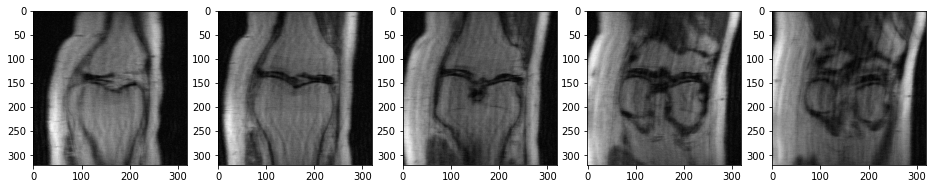

In [ ]:
slice_num = [12, 16, 19, 22, 24]
show_slices(img_3d, slice_num, cmap='gray')

1.2043776e-08 0.00035430153


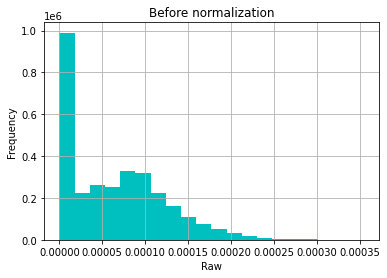

In [ ]:
img_flat = img_3d.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [ ]:
a = s.normalize(img_3d)
a.shape

(30, 320, 320)

0.0 1.0


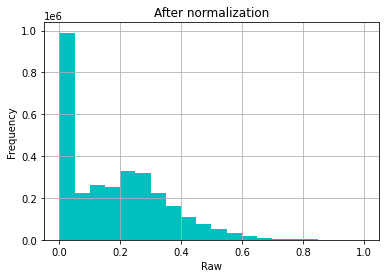

In [ ]:
img_flat = a.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("After normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [ ]:
# go back to original distribution
c = a * 0.00035430153 + 1.2043776e-08
c.shape

(30, 320, 320)

1.2043776e-08 0.00035431358


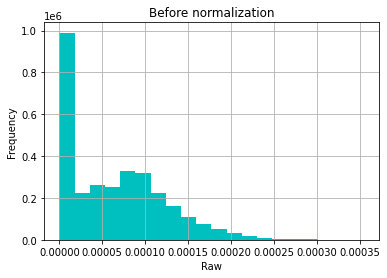

In [ ]:
img_flat = c.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [ ]:
test_npy_path ="/content/drive/My Drive/CSE499N/Single Coil testNPY"

In [ ]:
i=0
for file in tqdm(TEST_IMAGES_DIR_PATH[:]):
    i+=1
    
    hf = h5py.File(file)
    
    # transform and save low res image volume
    kspace_tensor = hf['kspace'][()]
    img_3d = sub_sample_kspace(kspace_tensor, _)
    
    # Save 
    np.save("{}/f{}.npy".format(test_npy_path, file[-16:-3]), img_3d)

    # Show progress
    print(i, file, "raw data - ", kspace_tensor.shape, "--", "input test volume - ", img_3d.shape)


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """
 12%|█▎        | 1/8 [00:00<00:02,  2.65it/s]

1 /content/drive/My Drive/CSE499N/Test/file1002452_v2.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 25%|██▌       | 2/8 [00:05<00:11,  1.86s/it]

2 /content/drive/My Drive/CSE499N/Test/file1002472_v2.h5 raw data -  (36, 640, 372) -- input test volume -  (36, 320, 320)


 38%|███▊      | 3/8 [00:10<00:13,  2.76s/it]

3 /content/drive/My Drive/CSE499N/Test/file1002480_v2.h5 raw data -  (40, 640, 368) -- input test volume -  (40, 320, 320)


 50%|█████     | 4/8 [00:16<00:15,  3.77s/it]

4 /content/drive/My Drive/CSE499N/Test/file1002508_v2.h5 raw data -  (48, 640, 368) -- input test volume -  (48, 320, 320)


 62%|██████▎   | 5/8 [00:21<00:12,  4.07s/it]

5 /content/drive/My Drive/CSE499N/Test/file1002504_v2.h5 raw data -  (34, 640, 322) -- input test volume -  (34, 320, 320)


 75%|███████▌  | 6/8 [00:28<00:09,  4.91s/it]

6 /content/drive/My Drive/CSE499N/Test/file1002571_v2.h5 raw data -  (39, 640, 368) -- input test volume -  (39, 320, 320)


 88%|████████▊ | 7/8 [00:33<00:04,  4.86s/it]

7 /content/drive/My Drive/CSE499N/Test/file1002522_v2.h5 raw data -  (36, 640, 368) -- input test volume -  (36, 320, 320)


100%|██████████| 8/8 [00:38<00:00,  4.87s/it]

8 /content/drive/My Drive/CSE499N/Test/file1002527_v2.h5 raw data -  (33, 640, 400) -- input test volume -  (33, 320, 320)


In [ ]:
test_path = glob.glob(os.path.join(test_npy_path,"*.npy"))
len(test_path)

8

In [ ]:
test_path[:4]

['/content/drive/My Drive/CSE499N/Single Coil testNPY/file1002452_v2.npy',
 '/content/drive/My Drive/CSE499N/Single Coil testNPY/file1002472_v2.npy',
 '/content/drive/My Drive/CSE499N/Single Coil testNPY/file1002480_v2.npy',
 '/content/drive/My Drive/CSE499N/Single Coil testNPY/file1002508_v2.npy']